In [1]:
#water malon 써서 어떤 건지 보여주자/

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

In [3]:
X = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/IXI_train.csv")
X_abs_test = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/IXI_test.csv")
X_Cobre_test = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/COBRE_test_scz.csv")
maping = pd.read_csv("Data_for_Final_Project_PAC2021_Spring_Challenge/thickness_order.csv")
X_Cobre_test["ICV"] = X_Cobre_test["ICV"] / 1000
#predict에서 scaling 할 때, training set의 mean과 variance를 사용하기 때문에 1000으로 나눔
non_sex_mask = np.isnan(X["Sex"])
non_age_mask = np.isnan(X["Age"])
non_mask = np.logical_or(non_sex_mask, non_age_mask)
X_impute = X[~non_mask]
index_target = ['ID', "Age"]
X_train = X_impute.drop(index_target,axis=1)
y_train = X_impute["Age"]
X_Cobre_test = X_Cobre_test.drop(index_target,axis=1)
X_abs_test = X_abs_test.drop(index_target,axis=1)
#change feature order of Cobre
order_list = [feature[0] for feature in maping.values.tolist()]
X_Cobre_test = X_Cobre_test[order_list]
X_Cobre_test.columns = X_abs_test.columns


X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=42)
y_train

80     43.0
129    32.0
135    25.0
475    48.0
77     39.0
       ... 
109    32.0
280    61.0
360    36.0
448    70.0
105    33.0
Name: Age, Length: 416, dtype: float64

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer


OHE = OneHotEncoder(drop='first')
#print(pd.DataFrame(OHE.fit_transform(X_train)))


std_preprocessing = make_pipeline( StandardScaler())


standard_preprocess = make_column_transformer((OHE, ["Sex"]),
                                      remainder=std_preprocessing)
standard_preprocess.fit(X_train)
standard_preprocess.named_transformers_
pd.DataFrame(standard_preprocess.transform(X_train))


,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.0,-0.330221,-0.611275,-0.044415,-1.590858,-0.752486,-0.258440,0.031035,-0.506506,1.194543,...,0.214197,-1.179160,0.295568,-0.897317,-0.388924,-0.455494,-0.380484,-0.766166,-0.647662,1.019574
1,1.0,2.566542,1.630142,-0.520773,0.890756,0.469503,0.262040,-0.579775,-0.289556,-0.418728,...,0.076731,0.945320,0.961695,1.208521,0.385652,0.953404,0.382651,-0.455186,0.203037,-1.128801
2,0.0,0.867161,-0.946741,-0.173450,-0.253712,1.057493,0.768084,0.006052,0.587517,1.279475,...,1.637661,-0.871460,2.763676,1.195089,0.930569,0.796710,0.540261,1.206661,1.754693,-0.105219
3,0.0,-1.349618,-2.216336,-1.097010,0.094651,-2.240458,-1.588372,-0.815597,0.490335,0.582849,...,-1.456761,-2.494977,-1.668446,-0.317836,-1.400468,-1.829356,-0.671556,-0.580217,-0.623724,0.675135
4,0.0,1.546788,1.777470,0.175186,-0.033264,1.459699,1.525284,1.318165,0.780159,-0.032884,...,1.231551,-0.145358,-1.056776,0.712878,-1.769800,0.909496,2.081136,0.587570,0.009477,0.363045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,1.0,1.019071,1.217251,1.427089,1.154736,1.152869,0.900547,0.108233,-0.381225,0.634604,...,0.513940,0.349005,0.366139,0.079264,0.704926,-0.367488,0.184851,0.833268,0.333020,-0.924392
412,1.0,-1.916001,-1.674562,-1.029926,-0.150128,-0.847435,-1.800482,-0.870832,-0.496227,0.012032,...,-1.954601,0.104043,-0.359371,-0.353675,1.330636,-1.273458,-1.502345,-0.745705,-0.172716,-0.409302
413,0.0,-0.443776,-0.633476,-2.125859,-0.720716,0.055645,0.292615,0.634018,0.279986,-1.244432,...,1.469713,0.868305,0.421003,-1.759751,0.401213,0.733112,2.307322,0.419693,1.564819,2.269473
414,1.0,-0.945976,0.768018,-0.995981,-0.699448,-0.595133,0.260749,-1.114590,-1.293784,-0.095732,...,-0.238972,0.194856,-0.884619,0.116069,-1.375185,-0.898941,-1.150905,0.111299,-0.910477,-1.293878


In [5]:
#demension reduction
#LDA is for Classification
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


#n_components == min(n_samples, n_features) - 1
pca_process = make_pipeline(standard_preprocess, PCA())
pca_visualize = make_pipeline(standard_preprocess, PCA(n_components=5))


saved!


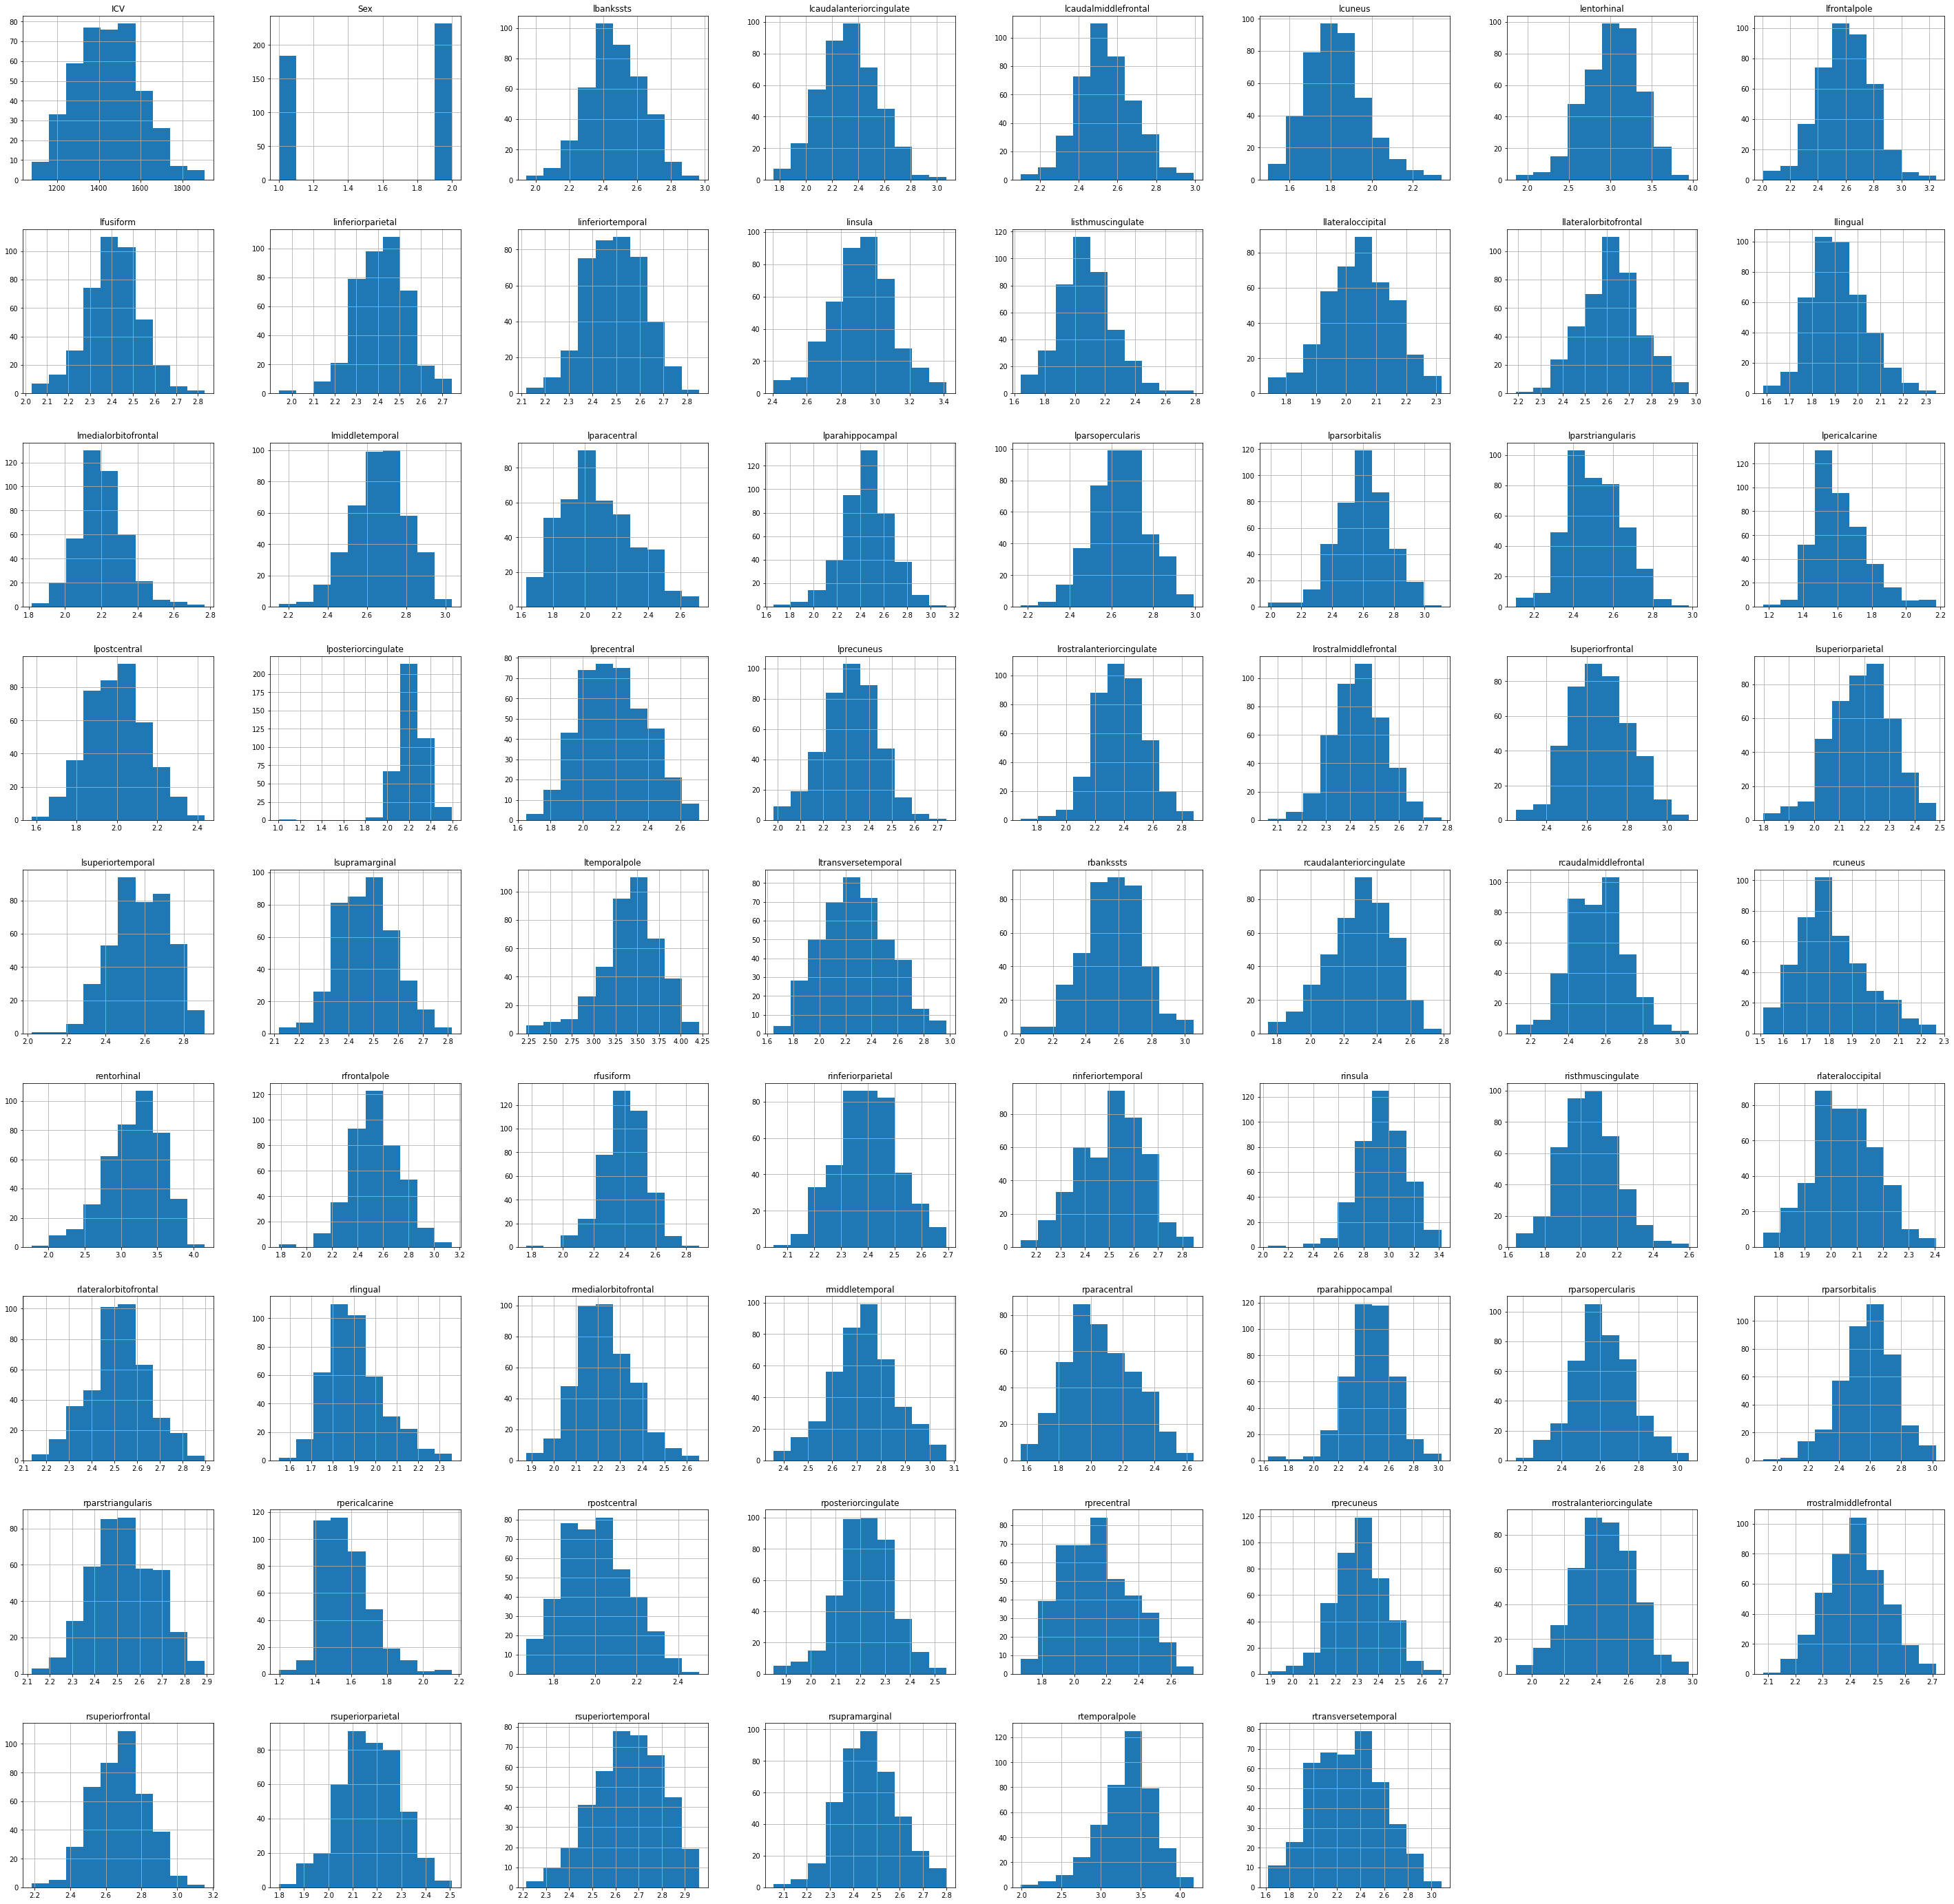

In [6]:
#data distribution visualize
X_train.hist(figsize=(50,50))
#plt.savefig("[기계학습] The-PAC2021-Challenge-Spring/images/feature_data_distribution.png")
print("saved!")

saved!


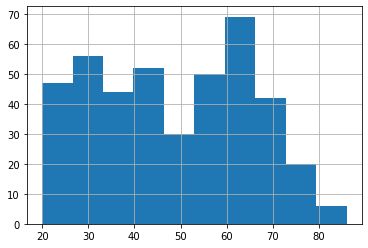

In [7]:
y_train.hist()
#plt.savefig("[기계학습] The-PAC2021-Challenge-Spring/images/target_distrubution.png")
print("saved!")

saved!


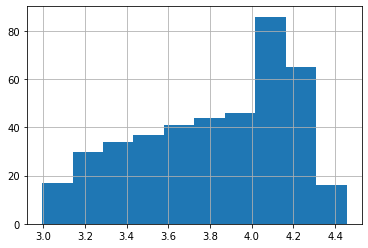

In [8]:
np.log(y_train).hist()
#plt.savefig("[기계학습] The-PAC2021-Challenge-Spring/images/log_target_distribution.png")
print("saved!")

In [9]:
#Original SVM regression
from sklearn.svm import SVR
from copy import deepcopy

svm_process = make_pipeline(standard_preprocess, SVR())

svm_process.fit(X_train,y_train)
#print(svm_process.named_steps["svr"])
#print(svm_process.predict(X_train))
#print(y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('svr', SVR())])

In [10]:
#PCA SVM regression
pca_svm_process = deepcopy(pca_process)
pca_svm_process.steps.append(["PCAsvr",SVR()])
#print(svm_process.get_params())
pca_svm_process.steps.pop()


['PCAsvr', SVR()]

In [11]:
#Original Elasticnet
from sklearn.linear_model import ElasticNet
elasticnet_process = make_pipeline(standard_preprocess,ElasticNet())


In [26]:
#PCA Elasticnet
from sklearn.linear_model import ElasticNet
elasticnet_search = {"pca__n_components" : [30, 40, 50],
                     "elasticnet__l1_ratio" : [0.2, 0.5, 0.8],
                     "elasticnet__alpha" : [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]}

elastic_model = make_pipeline(standard_preprocess, PCA(), ElasticNet())
elastic_grid = GridSearchCV(elastic_model,elasticnet_search,verbose=2)
elastic_grid.fit(X_train, y_train)
print(elastic_grid.best_estimator_)
best_elastic = elastic_grid.best_estimator_

print("test accuracy")
print(best_elastic.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(best_elastic.score(X_val,y_val))



Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=100, elasticnet__l1_

[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=1, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=1, 

[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.5, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.5, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.5, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.5, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.5, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.01, elasticnet__l1_ratio=0.5, pca__n_components=40; total time=   0.0s


[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=30; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=40; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=50; total time=   0.0s
[CV] END elasticnet__alpha=0.0001, elasticnet__l1_ratio=0.2, pca__n_components=50;

In [14]:
best_elastic
abs_expect = pd.DataFrame(best_elastic.predict(X_abs_test))
Cobre_expect = pd.DataFrame(best_elastic.predict(X_Cobre_test))

abs_expect.to_csv("temp_submit/_absresult.csv")
Cobre_expect.to_csv("temp_submit/_cobre.csv")

In [178]:
#PCA RIdage
from sklearn.linear_model import Ridge
pca_elasticnet_process = deepcopy(pca_process)

pca_elasticnet_process.steps.append(["PCARidge", ElasticNet()])
pca_elasticnet_process.get_params()
pca_elasticnet_process.steps.pop()

['PCARidge', ElasticNet()]

In [179]:
#Original Lasso
from sklearn.linear_model import Lasso
Lasso_process = make_pipeline(standard_preprocess, Lasso())

In [180]:
#PCA Lasso
from sklearn.linear_model import Lasso
pca_Lasso_process = deepcopy(pca_process)

pca_Lasso_process.steps.append(["PCALasso", ElasticNet()])
pca_Lasso_process.get_params()
pca_Lasso_process.steps.pop()

['PCALasso', ElasticNet()]

In [27]:
#Original Randomforest
from sklearn.ensemble import RandomForestRegressor
randomforest_process = make_pipeline(standard_preprocess, RandomForestRegressor())

X_train.shape
forest.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                StandardScaler())]),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    ['Sex'])])),
  ('pca', PCA()),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'columntransformer': ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                              StandardScaler())]),
                   transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                  ['Sex'])]),
 'pca': PCA(),
 'randomforestregressor': RandomForestRegressor(),
 'columntransformer__n_jobs': None,
 'columntransformer__remainder__memory': None,
 'columntransformer__remainder__steps': [('standardscaler', StandardScaler())],
 'columntransformer__remainder__verbose': False,
 'columntransformer__remainder__stan

In [39]:
#PCA Randomforest
from sklearn.ensemble import RandomForestRegressor

forest_params = {"randomforestregressor__ccp_alpha" : [1, 0.1, 0.01, 0.001],
                "randomforestregressor__max_features" : [35,36,37,38],
                "randomforestregressor__max_depth" : [4,5,6,7,8,9,10,11,12]}

sk = StratifiedKFold(n_splits=10,random_state=613,shuffle = True)
forest = make_pipeline(standard_preprocess, PCA(), RandomForestRegressor())

forest_gd = GridSearchCV(forest, forest_params, cv=sk, verbose=2)

forest_gd.fit(X_train, y_train)

print(forest_gd.best_estimator_)
best_forest = forest_gd.best_estimator_

print("test accuracy")
print(best_forest.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(best_forest.score(X_val,y_val))

abs_expect = pd.DataFrame(best_forest.predict(X_abs_test))
Cobre_expect = pd.DataFrame(best_forest.predict(X_Cobre_test))

abs_expect.to_csv("temp_submit/Randomforest_absresult.csv")
Cobre_expect.to_csv("temp_submit/Randomfroest_cobre.csv")

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=5, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=7, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=8, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomfores

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=10, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=10, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=10, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomfo

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=11, randomforestregressor__max_features=37; total time=   0.4s
[CV] END rand

[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=1, randomforestregressor__max_depth=12, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=4, randomforestregressor__max_features=35; total time=   0.2s
[CV] END ran

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=5, randomforestregressor__max_features=36; total time=   0.3s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=6, randomforestregressor__max_features=38; total time=   0.3s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=8, randomforestregressor__max_features=36; total time=   0.4s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=9, randomforestregressor__max_features=38; total time=   0.4s
[CV] E

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=11, randomforestregressor__max_features=36; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.1, randomforestregressor__max_depth=12, randomforestregressor__max_features=37; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=5, randomforestregressor__max_features=35; total time=   0.3s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=6, randomforestregressor__max_features=37; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=7, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=8, randomforestregressor__max_features=35; total time=   0.5s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=9, randomforestregressor__max_features=37; total time=   0.4s

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=10, randomforestregressor__max_features=38; total time=

[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.01, randomforestregressor__max_depth=12, randomforestregressor__max_features=36; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=37; total time=   0.2s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=38; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=4, randomforestregressor__max_features=38; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=6, randomforestregressor__max_features=35; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.3s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=7, randomforestregressor__max_features=37; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=8, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=8, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=8, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=9, randomforestregressor__max_features=35; total time=

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=36; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=10, randomforestregressor__max_features=37; tota

[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.5s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; total time=   0.4s
[CV] END randomforestregressor__ccp_alpha=0.001, randomforestregressor__max_depth=11, randomforestregressor__max_features=38; tota

In [36]:
#PCA ADAboosting
from sklearn.ensemble import AdaBoostRegressor
pd.DataFrame(forest_gd.cv_results_["mean_test_score"])
forest_gd.cv_results_

# from sklearn.compose import TransformedTargetRegressor
# log_regressor = TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp)
# cross_val_score(make_pipeline(preprocess, log_regressor), X_train, y_train, cv=5)



#618
# Pipeline(steps=[('columntransformer',
#                  ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
#                                                               StandardScaler())]),
#                                    transformers=[('onehotencoder',
#                                                   OneHotEncoder(drop='first'),
#                                                   ['Sex'])])),
#                 ('pca', PCA()),
#                 ('randomforestregressor',
#                  RandomForestRegressor(max_depth=9, max_features=35))])


#6015
# Pipeline(steps=[('columntransformer',
#                  ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
#                                                               StandardScaler())]),
#                                    transformers=[('onehotencoder',
#                                                   OneHotEncoder(drop='first'),
#                                                   ['Sex'])])),
#                 ('pca', PCA()),
#                 ('randomforestregressor',
#                  RandomForestRegressor(max_depth=11, max_features=38))])
# test accuracy


{'mean_fit_time': array([0.30418582, 0.3012233 , 0.31325953, 0.32333276, 0.32223382,
        0.32005248, 0.34767296, 0.36453552, 0.36771848, 0.38261168,
        0.38578348, 0.39554217, 0.3970484 , 0.40271308, 0.42741525,
        0.40809345, 0.41641724, 0.44424739, 0.43334506, 0.43383815,
        0.4585572 , 0.46796198, 0.47522337, 0.45817606, 0.4549933 ,
        0.45738535, 0.44929869, 0.46805837, 0.48870513, 0.4870065 ,
        0.47881379, 0.49327142, 0.5093183 , 0.51538453, 0.53544984,
        0.50265684, 0.46994057, 0.48221138, 0.4872046 , 0.5412591 ,
        0.5202503 , 0.54095943, 0.53281386, 0.5335202 , 0.56478701,
        0.57021573, 0.54416435, 0.56932282, 0.55880144, 0.52933152,
        0.5826879 , 0.56109724, 0.55743594, 0.55513415]),
 'std_fit_time': array([0.01712026, 0.00962784, 0.00917119, 0.02193586, 0.00763911,
        0.00352141, 0.0212777 , 0.0152542 , 0.00817201, 0.01961107,
        0.01973929, 0.01729201, 0.03215439, 0.02227361, 0.03289378,
        0.01504645, 0.010

In [13]:
#Original GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
GBM_process = make_pipeline(standard_preprocess, GradientBoostingRegressor())





abs_predict_data =  pd.DataFrame(best_forest.predict(X_abs_test))
abs_filtered_df = abs_predict_data.applymap(threshold_function)

Cobre_predict_data = pd.DataFrame(best_forest.predict(X_Cobre_test))
Cobre_filtered_df = Cobre_predict_data.applymap(threshold_function)

abs_filtered_df.to_csv("temp_submit/inovation_Randomforest_absresult.csv")
Cobre_filtered_df.to_csv("temp_submit/inovation_Randomfroest_cobre.csv")


y_val_predict_data = best_forest.predict(X_val)
y_val_predict_data =  pd.DataFrame(y_val_predict_data)
y_val_filtered_df = y_val_predict_data.applymap(threshold_function)

print("before filtering, accuracy")
print(best_forest.score(X_val,y_val), "\n\n\n")
print("After filtering, accuracy")
print(best_forest.score(X_val,filtered_df))

print(abs_filtered_df)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, filtered_df)
mse2 = mean_squared_error(y_val,best_forest.predict(X_val))
print(mse)
print(mse2)


NameError: name 'best_forest' is not defined

In [152]:
#PCA GBM
from sklearn.ensemble import GradientBoostingRegressor
pca_GBM_process = deepcopy(pca_process)
pca_GBM_process.steps.append(["PCA_GBM", GradientBoostingRegressor()])
pca_GBM_process.get_params()
pca_GBM_process.steps.pop()

['PCA_GBM', GradientBoostingRegressor()]

In [181]:
#Original XGBM
from xgboost import XGBRegressor
GBM_process = make_pipeline(standard_preprocess, XGBRegressor())




In [230]:
#PCA XGBM

#check_PCA = list(range(30,40, 2))
XGBM_seach_param = {
    "xgbregressor__n_estimators" : [250, 300, 350],
    "xgbregressor__learning_rate" : [0.01, 0.1, 0.01],
    "xgbregressor__max_depth" : [2, 4, 6],
    "xgbregressor__reg_alpha" : [0, 1, 2, 3]
}

pca_XGBM_process = make_pipeline(standard_preprocess, PCA(), XGBRegressor())

#pca_XGBM_process.get_params()
rsf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = 16516)#
sf =StratifiedKFold(n_splits=10, random_state=153)


grid_search = GridSearchCV(pca_XGBM_process, param_grid=XGBM_seach_param, cv=sf, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train
#fitting 시킴으로 평균값과 sigma, standard deviation, w 모델 저장
#n_job으로 쓸 cpu core
print(grid_result.best_estimator_)
XGBM = grid_result.best_estimator_

print("test accuracy")
print(XGBM.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(XGBM.score(X_val,y_val))

abs_expect = pd.DataFrame(XGBM.predict(X_abs_test))
Cobre_expect = pd.DataFrame(XGBM.predict(X_Cobre_test))

abs_expect.to_csv("temp_submit/absresult.csv")
Cobre_expect.to_csv("temp_submit/cobre.csv")
#print(grid_result.cv_results_)


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\user\anaconda3\lib\site-packages\sk

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex'])])),
                ('pca', PCA(n_components=32)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                       

In [215]:
import lightgbm
pca_XGBM_process.get_params()
#pca_XGBM_process.steps.append(["PCA_XGBM", XGBRegressor()])

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                StandardScaler())]),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    ['Sex'])])),
  ('pca', PCA()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=Non

In [29]:
#PCA XGBM
from xgboost import XGBRegressor
check_PCA = list(range(10, 60, 5))
check_PCA.append(None)
XGBM_seach_param = {
    "pca__n_components" : [30, 40, 50],
    "xgbregressor__n_estimators" : [100, 200],
    "xgbregressor__learning_rate" : [0.01, 0.1, 1, 10 ,100, 100],
    "xgbregressor__max_depth" : [2, 4, 6]
}

pca_XGBM_process = make_pipeline(standard_preprocess, PCA(), XGBRegressor())

#pca_XGBM_process.get_params()
rsf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state = 16516)########################rnadom vairlble
grid_search = GridSearchCV(pca_XGBM_process, param_grid=XGBM_seach_param,verbose=2)
grid_result = grid_search.fit(X_train, y_train)######################################## iloc을 바꿈
#fitting 시킴으로 평균값과 sigma, standard deviation, w 모델 저장

print(grid_result.best_estimator_)
XGBM = grid_result.best_estimator_

print("test accuracy")
print(XGBM.score(X_train,y_train),"\\n\n\n")

print("validation accuracy")
print(XGBM.score(X_val,y_val))

abs_expect = pd.DataFrame(XGBM.predict(X_abs_test))
Cobre_expect = pd.DataFrame(XGBM.predict(X_Cobre_test))

abs_expect.to_csv("temp_submit/absresult.csv")
Cobre_expect.to_csv("temp_submit/cobre.csv")
#print(grid_result.cv_results_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=4, xgbregressor__n_estimators=200; total time=   0.1s
[CV] END pca__n_components=30, xgbregressor__learning_rate=0.01, xgbregressor__m

[CV] END pca__n_components=40, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.2s
[CV] END pca__n_components=40, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.2s
[CV] END pca__n_components=40, xgbregressor__learning_rate=0.01, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.2s
[CV] END pca__n_components=40, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=40, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=40, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV] END pca__n_components=40, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=4, xgbregressor__n_estimators=100; total time=   0.0s
[CV

[CV] END pca__n_components=50, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=50, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=50, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=50, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=50, xgbregressor__learning_rate=0.1, xgbregressor__max_depth=6, xgbregressor__n_estimators=200; total time=   0.3s
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('onehotencoder',
                      

In [111]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
abs_before = pd.read_csv("temp_submit/absresult.csv")
cobre_before = pd.read_csv("temp_submit/cobre.csv")
abs_before = abs_before.iloc[:,1]
abs_before.round()

def threshold_function(df):
    decimal_part = df - np.floor(df)
    if (decimal_part <= 0.3):
        return np.floor(df)
    elif (0.7 <= decimal_part):
        return np.floor(df) + 1
    return df


XGB = XGBRegressor(n_estimators=300,random_state=0,reg_alpha=0,reg_lambda=1)


xgb = make_pipeline(standard_preprocess,PCA(n_components=32),XGB)
xgb.fit(X_train,y_train)

print("filtered accuracy")
filtered_df = pd.DataFrame(xgb.predict(X_val))
filtered_df = filtered_df.applymap(threshold_function)

#print(xgb.score(X_val,y_val))
print(xgb.score(X_val,filtered_df))


print(y_val,filtered_df)
#abs_before.apply(threshold_function)
#0.5에선 확실하지 않잖아?
#하지만 0.1, 0.2, 0.3과 0.7 0.8 0.9 같은 경우에는 filter해도 될 듯?

filtered accuracy
0.9998390193303341
229    47.0
30     63.0
39     34.0
226    38.0
127    68.0
207    61.0
320    60.0
215    45.0
474    71.0
79     32.0
470    81.0
410    60.0
78     37.0
398    53.0
288    67.0
281    26.0
72     52.0
96     23.0
160    55.0
0      36.0
400    37.0
84     32.0
380    63.0
369    63.0
432    58.0
317    60.0
176    29.0
180    28.0
18     24.0
9      22.0
441    62.0
462    68.0
75     25.0
238    46.0
297    53.0
420    32.0
55     56.0
93     57.0
376    76.0
81     38.0
336    44.0
464    56.0
213    41.0
177    27.0
189    73.0
74     46.0
151    64.0
Name: Age, dtype: float64             0
0   48.000000
1   56.000000
2   33.491695
3   49.583504
4   61.380821
5   61.545807
6   49.000000
7   58.389938
8   59.000000
9   46.000000
10  61.000000
11  37.634823
12  29.000000
13  57.000000
14  49.363972
15  36.000000
16  43.000000
17  29.559994
18  44.000000
19  45.000000
20  31.000000
21  47.000000
22  52.000000
23  65.000000
24  62.478584
25  54.00

In [32]:
pca_XGBM_process.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('standardscaler',
                                                StandardScaler())]),
                     transformers=[('onehotencoder', OneHotEncoder(drop='first'),
                                    ['Sex'])])),
  ('pca', PCA()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=Non